# IMPORT PACKEGES

In [87]:
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoLocator, AutoMinorLocator, LogLocator
import ast

# PLOT SETTINGS

In [88]:
# Font settings
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'serif'
mpl.rc('text', usetex=True)

# Tick settings
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.minor.size'] = 4

mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 2

# Axis linewidth
mpl.rcParams['axes.linewidth'] = 2

# Tick direction and enabling ticks on all sides
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# Function to apply custom tick locators and other settings to an Axes object
def apply_custom_settings(ax, leg, log_scale_y=False):

    if log_scale_y:
        # Use LogLocator for the y-axis if it's in log scale
        ax.set_yscale('log')
        ax.yaxis.set_major_locator(LogLocator(base=10.0))
        ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=100))
    else:
        # Use AutoLocator for regular scales
        ax.yaxis.set_major_locator(AutoLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
    
    # Apply the AutoLocator for the x-axis
    ax.xaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    
    # Legend settings
    leg.get_frame().set_edgecolor('w')
    leg.get_frame().set_linewidth(0.0)

# PHYSICAL CONSTANTS


In [89]:
class CGSUnitsConst:
    eV = 1.60218e-12  # erg

class PhysConst:
    c = 2.99792458e10  # cm/s
    c2 = c * c
    c4 = c2 * c2
    hbar = 1.05457266e-27  # erg s
    hbarc = hbar * c  # erg cm
    hc = hbarc*2*np.pi
    GF = (1.1663787e-5 / (1e9 * 1e9 * CGSUnitsConst.eV * CGSUnitsConst.eV))
    Mp = 1.6726219e-24  # g
    sin2thetaW = 0.23122
    kB = 1.380658e-16  # erg/K
    G = 6.67430e-8 # cm3 g−1 s-2
    Msun = 1.9891e33 # g

# DIRECTORY PATH

In [90]:
###################################################
# SEQUENTIAL INSTABILITY
directory_path = '/mnt/scratch/erick/ffcei/papersim/sequential_instability/seq_ins_1xem/slow_left_4p' # QKE simulation 1xem
# directory_path = '/mnt/scratch/erick/ffcei/papersim/sequential_instability/seq_ins_8xem/slow_left_4p' # QKE simulation 8xem

directory_path = '/mnt/scratch/erick/ffcei/papersim/sequential_instability/seq_ins_1xem/sudden_asymmetric_4p' # Sudden simulation 1xem
# directory_path = '/mnt/scratch/erick/ffcei/papersim/sequential_instability/seq_ins_8xem/sudden_asymmetric_4p' # Sudden simulation 8xem

###################################################
# SUBGRID HOMOGENIZATION
# directory_path = '/mnt/scratch/erick/ffcei/papersim/subgrid_homogenization/bgk_1xem' # BGK 1xem
# directory_path = '/mnt/scratch/erick/ffcei/papersim/subgrid_homogenization/bgk_8xem' # BGK 8xem

###################################################
# IRREVERSIBILITY
# directory_path = '/mnt/scratch/erick/ffcei/papersim/irreversibility/cont_reve_1xem/slow_left_4p_reve_1ra' # QKE + P_T randomize in the transition emission/absorption | 1xem
# directory_path = '/mnt/scratch/erick/ffcei/papersim/irreversibility/cont_reve_8xem/slow_left_4p_reve_1ra' # QKE + P_T randomize in the transition emission/absorption | 8xem

file_list = glob.glob(directory_path + '/plt*.h5')
file_list.sort(key=lambda x: int(x.split('plt')[1].split('.h5')[0]))

In [91]:
def read_param_file(filename):
    def set_nested(d, k, v):
        keys = k.split('.')
        for key in keys[:-1]:
            d = d.setdefault(key, {})
        d[keys[-1]] = v

    params = {}
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#') or '=' not in line:
                continue
            key, val = map(str.strip, line.split('=', 1))
            set_nested(params, key, ast.literal_eval(val))
    return params

# Usage
params = read_param_file(directory_path+"/inputs_fast_flavor_nonzerok")

In [92]:
# ['N00_Re', 'N00_Rebar', 
# 'N01_Im', 'N01_Imbar', 
# 'N01_Re', 'N01_Rebar', 
# 'N11_Re', 'N11_Rebar',
# 'TrHN', 'Vphase',
# 'pos_x', 'pos_y', 'pos_z',
# 'pupt', 'pupx', 'pupy', 'pupz',
# 'time', 'x', 'y', 'z']

time_seconds = np.zeros(len(file_list))
Pz_pzpos_av  = np.zeros(len(file_list))
Pz_pzneg_av  = np.zeros(len(file_list))
Pz_pxpos_av  = np.zeros(len(file_list))
Pz_pxneg_av  = np.zeros(len(file_list))

N_pzpos_av  = np.zeros((len(file_list),2,2))
N_pzneg_av  = np.zeros((len(file_list),2,2))
N_pxpos_av  = np.zeros((len(file_list),2,2))
N_pxneg_av  = np.zeros((len(file_list),2,2))


for i, file_name in enumerate(file_list):

    with h5py.File(file_name, 'r') as f:
        data_dict = {}
        for key in f.keys():
            data_dict[key] = np.array(f[key][:])

    px = np.array(data_dict['pupx']) 
    py = np.array(data_dict['pupy'])
    pz = np.array(data_dict['pupz'])

    mask_pz_pos = (pz>0) & (px==0)
    mask_pz_neg = (pz<0) & (px==0)
    mask_px_pos = (px>0) & (pz==0)
    mask_px_neg = (px<0) & (pz==0)

    z = np.array(data_dict['z'])

    Nee   = np.array(data_dict['N00_Re'])
    Nuu   = np.array(data_dict['N11_Re'])
    NeuRe = np.array(data_dict['N01_Re'])
    NeuIm = np.array(data_dict['N01_Im'])

    if i == 0:
        print('Initial')
        Ntotal = np.sum(Nee + Nuu)
        print('Ntotal:', Ntotal)
        ELNXLN = np.sum(Nee - Nuu)
        print('ELNXLN:', ELNXLN)
        print('')
    if i == len(file_list)-1:
        print('Final')
        Ntotal = np.sum(Nee + Nuu)
        print('Ntotal:', Ntotal)
        ELNXLN = np.sum(Nee - Nuu)
        print('ELNXLN:', ELNXLN)
        print('')

    Pz = 0.5 * ( Nee - Nuu )
    Px = NeuRe
    Py = NeuIm

    time_seconds[i] = data_dict['time'][0]
    Pz_pzpos_av[i]  = np.average(Pz[mask_pz_pos])
    Pz_pzneg_av[i]  = np.average(Pz[mask_pz_neg])
    Pz_pxpos_av[i]  = np.average(Pz[mask_px_pos])
    Pz_pxneg_av[i]  = np.average(Pz[mask_px_neg])

    N_pzpos_av[i,0,0] = np.average(np.array(data_dict['N00_Re'])[mask_pz_pos])
    N_pzpos_av[i,1,1] = np.average(np.array(data_dict['N11_Re'])[mask_pz_pos])
    N_pzpos_av[i,0,1] = np.average(np.sqrt(np.array(data_dict['N01_Re'])[mask_pz_pos]**2+np.array(data_dict['N01_Im'])[mask_pz_pos]))

    N_pzneg_av[i,0,0] = np.average(np.array(data_dict['N00_Re'])[mask_pz_neg])
    N_pzneg_av[i,1,1] = np.average(np.array(data_dict['N11_Re'])[mask_pz_neg])
    N_pzneg_av[i,0,1] = np.average(np.sqrt(np.array(data_dict['N01_Re'])[mask_pz_neg]**2+np.array(data_dict['N01_Im'])[mask_pz_neg]))

    N_pxpos_av[i,0,0] = np.average(np.array(data_dict['N00_Re'])[mask_px_pos])
    N_pxpos_av[i,1,1] = np.average(np.array(data_dict['N11_Re'])[mask_px_pos])
    N_pxpos_av[i,0,1] = np.average(np.sqrt(np.array(data_dict['N01_Re'])[mask_px_pos]**2+np.array(data_dict['N01_Im'])[mask_px_pos]))

    N_pxneg_av[i,0,0] = np.average(np.array(data_dict['N00_Re'])[mask_px_neg])
    N_pxneg_av[i,1,1] = np.average(np.array(data_dict['N11_Re'])[mask_px_neg])
    N_pxneg_av[i,0,1] = np.average(np.sqrt(np.array(data_dict['N01_Re'])[mask_px_neg]**2+np.array(data_dict['N01_Im'])[mask_px_neg]))   

Initial
Ntotal: 6.114200000000001e+34
ELNXLN: 3.668500000000001e+34

Final
Ntotal: 6.114199999999997e+34
ELNXLN: 3.668499999999998e+34



In [93]:
# Domain size in 3D index space
ncell = params['ncell'] # Number of cells in x, y, z

Lx = params['Lx'] # Domain size in x (cm)
Ly = params['Ly'] # Domain size in y (cm)
Lz = params['Lz'] # Domain size in z (cm)

dx = Lx/ncell[0] #cm
dy = Ly/ncell[1] #cm
dz = Lz/ncell[2] #cm

cellvolume = dx*dy*dz # ccm

### COMPUTE MU

In [94]:
nee_pz_pos_init = 4.8913e+32 # 1/ccm
nuu_pz_neg_init = 2.4456e+32 # 1/ccm

nee_pzpos = 4.8913e+32 # 1/ccm
nxx_pzpos = 0.0 # 1/ccm

nee_pzneg = 0.0 # 1/ccm
nxx_pzneg = 2.4456e+32 # 1/ccm

nee_pxpos = 2.4456e+32 # 1/ccm
nxx_pxpos = 0.0 # 1/ccm

nee_pxneg = 2.4456e+32 # 1/ccm
nxx_pxneg = 0.0 # 1/ccm

mu_t = 1.0 / (np.array(np.sqrt(2)*PhysConst.GF*(nee_pzpos+nxx_pzpos+nee_pzneg+nxx_pzneg+nee_pxpos+nxx_pxpos+nee_pxneg+nxx_pxneg))*(PhysConst.c**3*PhysConst.hbar**2)) # seconds
mu_l = 1.0 / (np.array(np.sqrt(2)*PhysConst.GF*(nee_pzpos+nxx_pzpos+nee_pzneg+nxx_pzneg+nee_pxpos+nxx_pxpos+nee_pxneg+nxx_pxneg))*(PhysConst.c**2*PhysConst.hbar**2)) # cm


### COMPUTE SIGMA

In [95]:
print(N_pzpos_av.shape)
N_all = np.stack([N_pzpos_av, N_pzneg_av, N_pxpos_av, N_pxneg_av], axis=1)
print(N_all.shape)  # should be (n, 4, 2, 2)

GnPos = np.zeros(len(file_list))
GnNeg = np.zeros(len(file_list))

domega = 4*np.pi / 4

for i in range(N_all.shape[0]):
    for j in range(N_all.shape[1]):
        Gn = np.sqrt(2)*PhysConst.GF*(PhysConst.hbarc**3/PhysConst.hbar) * ( N_all[i,j,0,0] - N_all[i,j,1,1] ) * ( domega / 4*np.pi ) / cellvolume
        if (Gn<0):
            GnNeg[i] += -1 * Gn
        else:
            GnPos[i] += Gn

sigma = np.sqrt( GnPos * GnNeg ) # 1/seconds
tau = 1.0 / sigma # seconds

(153, 2, 2)
(153, 4, 2, 2)


/tmp/ipykernel_57853/1089624288.py:19: RuntimeWarning: divide by zero encountered in divide
  tau = 1.0 / sigma # seconds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


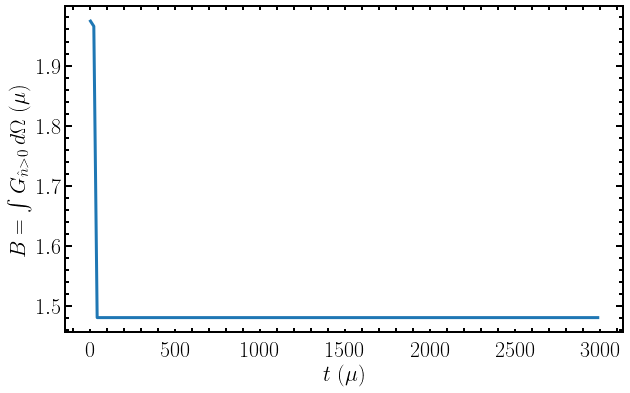

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


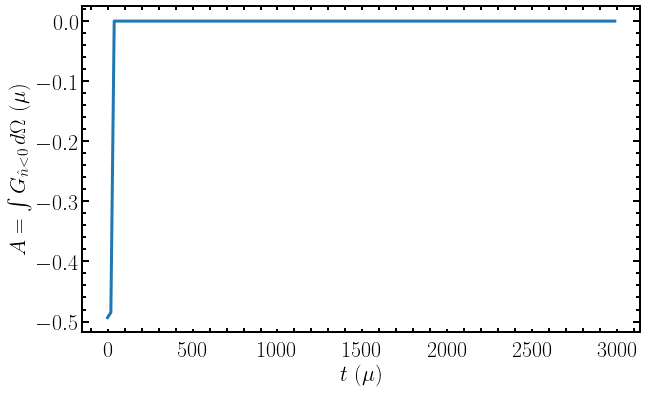

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


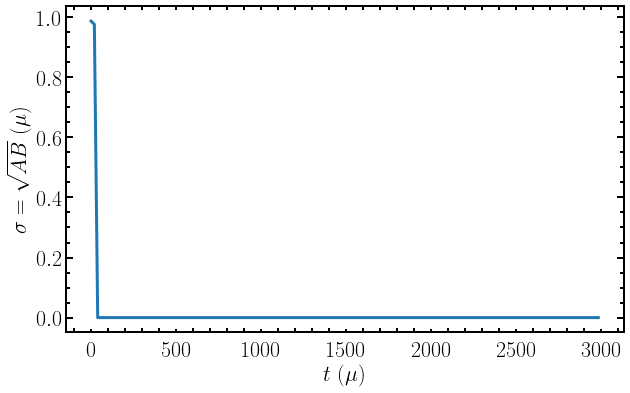

In [96]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_seconds/mu_t, GnPos*mu_t, color='C0', linestyle='solid', linewidth=3)
ax.set_xlabel(r'$t$ ($\mu$)')
ax.set_ylabel(r'$B=\int G_{\hat{n}>0}\,d\Omega$ ($\mu$)')
# ax.set_yscale('log')
leg = ax.legend(framealpha=0.0, ncol=1, fontsize=20)
apply_custom_settings(ax, leg, False)
plt.savefig("./plots/GnPos_"+directory_path.split('/')[-1]+".pdf", bbox_inches='tight')
plt.show()
plt.close(fig)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_seconds/mu_t, -1*GnNeg*mu_t, color='C0', linestyle='solid', linewidth=3)
ax.set_xlabel(r'$t$ ($\mu$)')
ax.set_ylabel(r'$A=\int G_{\hat{n}<0}\,d\Omega$ ($\mu$)')
# ax.set_yscale('log')
leg = ax.legend(framealpha=0.0, ncol=1, fontsize=20)
apply_custom_settings(ax, leg, False)
plt.savefig("./plots/GnNeg_"+directory_path.split('/')[-1]+".pdf", bbox_inches='tight')
plt.show()
plt.close(fig)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_seconds/mu_t, sigma*mu_t, color='C0', linestyle='solid', linewidth=3)
ax.set_xlabel(r'$t$ ($\mu$)')
ax.set_ylabel(r'$\sigma=\sqrt{AB}$ ($\mu$)')
# ax.set_yscale('log')
leg = ax.legend(framealpha=0.0, ncol=1, fontsize=20)
apply_custom_settings(ax, leg, False)
plt.savefig("./plots/sigma_"+directory_path.split('/')[-1]+".pdf", bbox_inches='tight')
plt.show()
plt.close(fig)

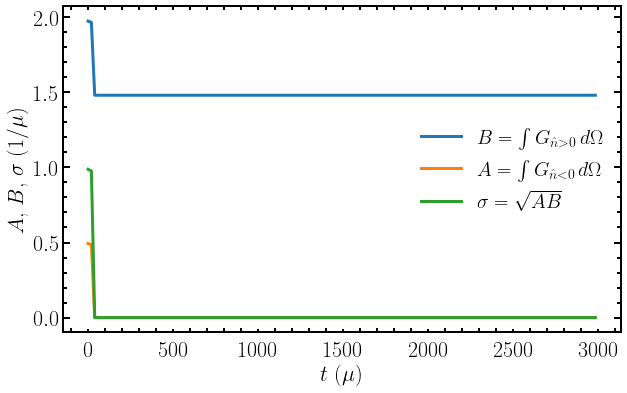

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_seconds/mu_t, GnPos*mu_t, color='C0', label=r'$B=\int G_{\hat{n}>0}\,d\Omega$', linestyle='solid', linewidth=3)
ax.plot(time_seconds/mu_t, GnNeg*mu_t, color='C1', label=r'$A=\int G_{\hat{n}<0}\,d\Omega$', linestyle='solid', linewidth=3)
ax.plot(time_seconds/mu_t, sigma*mu_t, color='C2', label=r'$\sigma=\sqrt{AB}$', linestyle='solid', linewidth=3)
ax.set_xlabel(r'$t$ ($\mu$)')
ax.set_ylabel(r'$A$, $B$, $\sigma$ ($1/\mu$)')
# ax.set_yscale('log')
leg = ax.legend(framealpha=0.0, ncol=1, fontsize=20)
apply_custom_settings(ax, leg, False)
plt.savefig("./plots/ABsigma_"+directory_path.split('/')[-1]+".pdf", bbox_inches='tight')
plt.show()
plt.close(fig)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


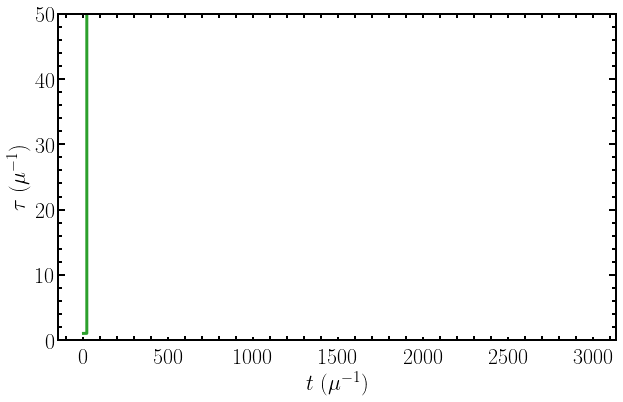

time_mu_sudden_asymmetric_4p=[0.0, 19.634750083307125, 39.269500166616375, 58.904250249925624, 78.53900033323487, 98.17375041654412, 117.80850049986348, 137.44325058319708, 157.07800066653067, 176.71275074986428, 196.34750083319787, 215.98225091653148, 235.61700099986507, 255.25175108319866, 274.88650116653224, 294.5212512498658, 314.15600133319947, 333.79075141653306, 353.42550149986664, 373.0602515832002, 392.6950016665338, 412.32975174986746, 431.96450183320104, 451.59925191646994, 471.23400199970615, 490.86875208294236, 510.50350216617863, 530.1382522494148, 549.773002332651, 569.4077524158872, 589.0425024991234, 608.6772525823596, 628.3120026655959, 647.9467527488321, 667.5815028320683, 687.2162529153045, 706.8510029985407, 726.4857530817769, 746.1205031650131, 765.7552532482493, 785.3900033314856, 805.0247534147218, 824.659503497958, 844.2942535811943, 863.9290036644305, 883.563753747603, 903.1985038306444, 922.8332539136859, 942.4680039967274, 962.1027540797688, 981.737504162810

In [100]:
fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(time_seconds/mu_t, GnPos*mu_t, color='C0', label=r'$B=\int G_{\hat{n}>0}\,d\Omega$', linestyle='solid', linewidth=3)
# ax.plot(time_seconds/mu_t, GnNeg*mu_t, color='C1', label=r'$A=\int G_{\hat{n}<0}\,d\Omega$', linestyle='solid', linewidth=3)

tau_plot = np.copy(tau)
tau_plot[np.isinf(tau_plot)] = 1000
ax.set_ylim(bottom=0, top=50)

ax.plot(time_seconds/mu_t, tau_plot/mu_t, color='C2', linestyle='solid', linewidth=3)
ax.set_xlabel(r'$t$ ($\mu^{-1}$)')
ax.set_ylabel(r'$\tau$ ($\mu^{-1}$)')
# ax.set_yscale('log')
leg = ax.legend(framealpha=0.0, ncol=1, fontsize=20)
apply_custom_settings(ax, leg, False)
plt.savefig("./plots/tau_"+directory_path.split('/')[-1]+".pdf", bbox_inches='tight')
plt.show()
plt.close(fig)

print(f'time_mu_{directory_path.split("/")[-1]}={list(time_seconds/mu_t)}')
print(f'tau_mu_{directory_path.split("/")[-1]}={list(tau/mu_t)}')
print(f'')
